In [13]:
include("MiniCollectiveSpins.jl")
using PyPlot
using Statistics
using JLD2
import PhysicalConstants.CODATA2018: c_0
using Unitful
using ProgressMeter
using NonlinearSolve
using SteadyStateDiffEq
using Libdl
using Symbolics
using OrdinaryDiffEq

In [14]:
""" Prepare the initial vector u0 """
function u0_CFunction(phi_array, theta_array, op_list)
    u0 = ones(ComplexF64, length(op_list))
    for i in 1:length(op_list)
        if length(op_list[i]) == 1
            j = Int(op_list[i][1] % 10^floor(log10(abs(op_list[i][1]))-1)) # Atom nbr
            if parse(Int, string(op_list[i][1])[1:2]) == 22
                u0[i] = cos(theta_array[j]/2)^2
            elseif parse(Int, string(op_list[i][1])[1:2]) == 21
                u0[i] = cos(theta_array[j]/2)*exp(1im*phi_array[j])*sin(theta_array[j]/2)
            else
                println(op_list[i][1])
            end
        end

        if length(op_list[i]) == 2
            for op in op_list[i]
                j = Int(op % 10^floor(log10(abs(op))-1)) # Atom nbr
                if parse(Int, string(op)[1:2]) == 22
                    u0[i] *= cos(theta_array[j]/2)^2
                elseif parse(Int, string(op)[1:2]) == 21
                    u0[i] *= cos(theta_array[j]/2)*exp(1im*phi_array[j])*sin(theta_array[j]/2)
                elseif parse(Int, string(op)[1:2]) == 12
                    u0[i] *= cos(theta_array[j]/2)*exp(-1im*phi_array[j])*sin(theta_array[j]/2)
                else
                    println(op)
                end
            end
        end
    end
    return u0
end

""" Function loading the block subfunction when a lot of equations are involved """
function load_f(fname::String, libpath::String)
	lib = Libdl.dlopen(libpath)
	fptr = Libdl.dlsym(lib, fname)
	return (du, u, params) -> ccall(fptr, Cvoid, (Ptr{ComplexF64}, Ptr{ComplexF64}, Ptr{ComplexF64}), du, u, params)
end

load_f

### Define the system

In [15]:
# Nbr of particles
N_list = [2:15;];

# Normalisation parameters
λ = 421e-9
γ = 32.7e6 # In Hz

# Physical values
ω0 = (2π*ustrip(c_0)/λ)
ωl = ω0
kl = [ustrip(c_0)/ωl, 0, 0] # Laser along x
Ω_RO = 1e7 # Taken from Barbut arXiv:2412.02541v1

# Normalization
ω0 = ω0 / γ
ωl = ωl / γ
kl = kl * λ
Ω_RO = Ω_RO / γ

# Quantization axis along z
e = [0, 0, 1.]

# Integration parameter
tstep = 0.1
T = [0:tstep:10;]; # Normalised time

In [16]:
# Prepare the wrapper
const N_FUNCS = length(N_list)  # Total function nbr
const functions = Vector{Function}(undef, N_FUNCS)

for (i, N) in enumerate(N_list)
    libpath ="libs/liballfuncs_$N.dll"
    functions[i] = load_f("diffeqf", libpath)
end

# Compute stationary state for each atom number

In [17]:
popup_SS_QC = []
popup_QC = []

@showprogress for (i, N) in enumerate(N_list)
    # Load atom position
    @load "../../Model2/Increasing_density_time_evolution/r0/r0_N_$N.jdl2" r0

    # Normalize the position vectors
    r0 = r0 / λ

    # Compute the Ω and Γ matrices of the electric dipole-dipole interaction using CollectiveSpins
    system = SpinCollection(r0, e, gammas=1.)
    Ω_CS = OmegaMatrix(system)
    Γ_CS = GammaMatrix(system)
    Γij_ = [Γ_CS[i, j] for i = 1:N for j=1:N]
    Ωij_ = [Ω_CS[i, j] for i = 1:N for j=1:N if i≠j]
    exp_RO_ = [exp(1im*r0[i]'kl) for i = N:-1:1] # We go in the decreasing direction to avoid exp_RO(10) being replace by exp_RO(1)0
    conj_exp_RO_ = [exp(-1im*r0[i]'kl) for i = N:-1:1]
    p0 = ComplexF64.([Γij_; Ωij_; exp_RO_; conj_exp_RO_; Ω_RO/2])

    # Prepare the guess for the steady state
    @load "op_list/op_list_$N.jdl2" op_list
    phi_array, theta_array = zeros(N), ones(N)*π
    u0 = u0_CFunction(phi_array, theta_array, op_list)
    
    # Load the functions
    fsolve(du, u, p, t) = functions[i](du, u, p0)

    # Find stationnary state
    prob_ss = SteadyStateProblem(fsolve, u0)
    sol = solve(prob_ss, SSRootfind())
    stationnary_state = sum(real(sol[1:N]))
    push!(popup_SS_QC, stationnary_state)

    # Compute time evolution for plot
    prob = OrdinaryDiffEq.ODEProblem(fsolve, u0, (T[1], T[end]))
    sol = OrdinaryDiffEq.solve(prob, OrdinaryDiffEq.DP5(), saveat=T;
                reltol=1.0e-6,
                abstol=1.0e-8).u
    push!(popup_QC, [sum(real(sol[i][1:N])) for i=1:length(T)])
end
nothing

Progress: 100%|█████████████████████████████████████████| Time: 0:18:10


# Plots

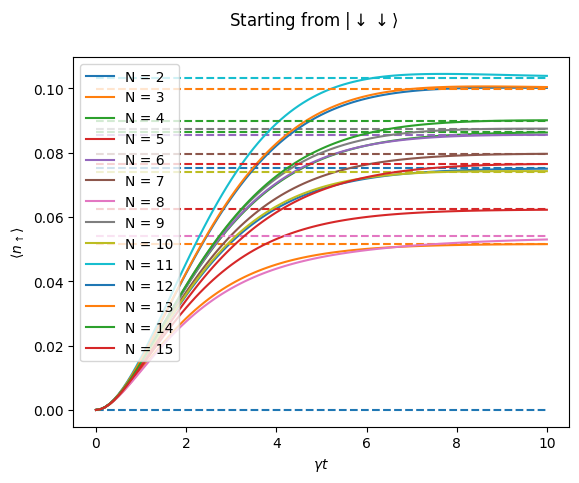

In [18]:
figure()
for (i, N) in enumerate(N_list)
    line, = plot(T, popup_QC[i]/N, label="N = $N")
    hlines(popup_SS_QC[i]/N, T[1], T[end], color = line.get_color(), linestyle="--")
end
xlabel(L"$\gamma t$")
ylabel(L"$\langle  n_{\uparrow} \rangle $")
suptitle(L"Starting from $|\downarrow \downarrow \rangle $")
legend()
pygui(false); gcf()
# pygui(true); show()

### Compare with previous result to check MiniCollectiveSpins

In [19]:
new_popup_QC = popup_QC;

In [20]:
@load "old_popup_vary_[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15].jld2" popup_QC
old_popup_QC = popup_QC;

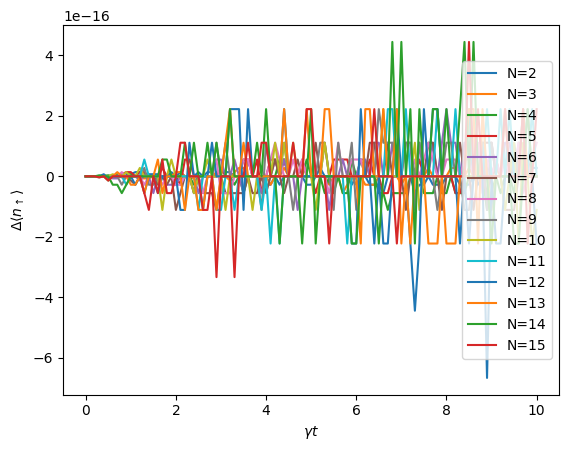

In [21]:
close("all")
figure()
for i in 1:length(new_popup_QC)
    plt.plot(T, old_popup_QC[i]-new_popup_QC[i], label="N=$(N_list[i])")
end
legend()
xlabel(L"\gamma t")
ylabel(L"\Delta \langle n_\uparrow \rangle")
pygui(false); gcf()
# pygui(true); show()